In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [ ]:


class Swish(nn.Module):
    """Swish activation function: x * sigmoid(x)"""
    def forward(self, x):
        return x * torch.sigmoid(x)


class SqueezeExcitation(nn.Module):
    """Squeeze-and-Excitation module"""
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            Swish(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class MBConvBlock(nn.Module):
    """Mobile Inverted Bottleneck Convolution Block"""
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio=0.25, drop_rate=0.0):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.use_residual = stride == 1 and in_channels == out_channels
        
        # Expansion phase
        expanded_channels = in_channels * expand_ratio
        self.expand_conv = None
        if expand_ratio != 1:
            self.expand_conv = nn.Sequential(
                nn.Conv2d(in_channels, expanded_channels, 1, bias=False),
                nn.BatchNorm2d(expanded_channels),
                Swish()
            )
        
        # Depthwise convolution
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(expanded_channels, expanded_channels, kernel_size, stride, 
                     padding=kernel_size//2, groups=expanded_channels, bias=False),
            nn.BatchNorm2d(expanded_channels),
            Swish()
        )
        
        # Squeeze-and-Excitation
        self.se = None
        if se_ratio > 0:
            se_channels = max(1, int(in_channels * se_ratio))
            self.se = SqueezeExcitation(expanded_channels, se_channels)
        
        # Output projection
        self.project_conv = nn.Sequential(
            nn.Conv2d(expanded_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # Dropout
        self.dropout = nn.Dropout2d(drop_rate) if drop_rate > 0 else None

    def forward(self, x):
        identity = x
        
        # Expansion
        if self.expand_conv is not None:
            x = self.expand_conv(x)
        
        # Depthwise convolution
        x = self.depthwise_conv(x)
        
        # Squeeze-and-Excitation
        if self.se is not None:
            x = self.se(x)
        
        # Output projection
        x = self.project_conv(x)
        
        # Dropout and residual connection
        if self.use_residual:
            if self.dropout is not None:
                x = self.dropout(x)
            x = x + identity
        
        return x


class EfficientNet(nn.Module):
    """EfficientNet implementation"""
    def __init__(self, num_classes=1000, width_mult=1.0, depth_mult=1.0, dropout_rate=0.2, drop_connect_rate=0.2):
        super(EfficientNet, self).__init__()
        
        # EfficientNet-B4 base configuration
        # [expand_ratio, channels, repeats, stride, kernel_size]
        base_config = [
            [1, 16, 1, 1, 3],   # Stage 1
            [6, 24, 2, 2, 3],   # Stage 2
            [6, 40, 2, 2, 5],   # Stage 3
            [6, 80, 3, 2, 3],   # Stage 4
            [6, 112, 3, 1, 5],  # Stage 5
            [6, 192, 4, 2, 5],  # Stage 6
            [6, 320, 1, 1, 3],  # Stage 7
        ]
        
        # Apply width and depth multipliers
        def round_filters(filters, multiplier):
            if not multiplier:
                return filters
            filters *= multiplier
            new_filters = max(8, int(filters + 4) // 8 * 8)
            if new_filters < 0.9 * filters:
                new_filters += 8
            return int(new_filters)
        
        def round_repeats(repeats, multiplier):
            if not multiplier:
                return repeats
            return int(math.ceil(multiplier * repeats))
        
        # Stem
        stem_channels = round_filters(32, width_mult)
        self.stem = nn.Sequential(
            nn.Conv2d(3, stem_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(stem_channels),
            Swish()
        )
        
        # Build blocks
        self.blocks = nn.ModuleList()
        in_channels = stem_channels
        total_blocks = sum([round_repeats(config[2], depth_mult) for config in base_config])
        block_idx = 0
        
        for expand_ratio, channels, repeats, stride, kernel_size in base_config:
            out_channels = round_filters(channels, width_mult)
            repeats = round_repeats(repeats, depth_mult)
            
            for i in range(repeats):
                # Drop connect rate increases linearly
                drop_rate = drop_connect_rate * block_idx / total_blocks
                
                self.blocks.append(MBConvBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride if i == 0 else 1,
                    expand_ratio=expand_ratio,
                    se_ratio=0.25,
                    drop_rate=drop_rate
                ))
                in_channels = out_channels
                block_idx += 1
        
        # Head
        head_channels = round_filters(1280, width_mult)
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, head_channels, 1, bias=False),
            nn.BatchNorm2d(head_channels),
            Swish()
        )
        
        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(head_channels, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Stem
        x = self.stem(x)
        
        # Blocks
        for block in self.blocks:
            x = block(x)
        
        # Head
        x = self.head(x)
        
        # Classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x


def efficientnet_b4(num_classes=1000, pretrained=False):
    """
    EfficientNet-B4 model
    
    Args:
        num_classes (int): Number of classification classes
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    
    Returns:
        EfficientNet model
    """
    # EfficientNet-B4 scaling parameters
    model = EfficientNet(
        num_classes=num_classes,
        width_mult=1.4,    # phi = 3, width = 1.4
        depth_mult=1.8,    # phi = 3, depth = 1.8
        dropout_rate=0.4,
        drop_connect_rate=0.2
    )
    
    if pretrained:
        # Note: You would need to implement loading pretrained weights here
        # For now, we'll just return the model without pretrained weights
        print("Warning: Pretrained weights not implemented for custom EfficientNet-B4")
    
    return model


# Convenience function to match timm's interface
def create_model(model_name, pretrained=False, num_classes=1000):
    """
    Create model function to match timm's interface
    
    Args:
        model_name (str): Model name (e.g., 'tf_efficientnet_b4_ns')
        pretrained (bool): Whether to load pretrained weights
        num_classes (int): Number of output classes
    
    Returns:
        Model instance
    """
    if 'efficientnet_b4' in model_name.lower():
        return efficientnet_b4(num_classes=num_classes, pretrained=pretrained)
    else:
        raise ValueError(f"Model {model_name} not supported")


if __name__ == "__main__":
    # Test the model
    model = efficientnet_b4(num_classes=1000)
    print(f"Model created successfully!")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test forward pass
    x = torch.randn(1, 3, 224, 224)
    with torch.no_grad():
        output = model(x)
    print(f"Output shape: {output.shape}")


Model created successfully!
Total parameters: 19,341,616
Output shape: torch.Size([1, 1000])


In [5]:
images = os.listdir('/kaggle/input/cassava-leaf-disease-classification/train_images')
len(images)

21397

In [7]:
import pandas as pd
df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
df.columns

Index(['image_id', 'label'], dtype='object')

In [8]:
len(df)

21397

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class CassavaDataset(Dataset):
    """
    Custom Dataset for Cassava Leaf Disease Classification
    """
    def __init__(self, csv_file, img_dir, transform=None, is_test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations
            img_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied on a sample
            is_test (bool): If True, dataset is for testing (no labels)
        """
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
        # Disease class mapping
        self.class_names = {
            0: 'Cassava Bacterial Blight (CBB)',
            1: 'Cassava Brown Streak Disease (CBSD)',
            2: 'Cassava Green Mottle (CGM)',
            3: 'Cassava Mosaic Disease (CMD)',
            4: 'Healthy'
        }
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image path
        img_name = self.df.iloc[idx]['image_id']
        img_path = os.path.join(self.img_dir, img_name)
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        # Get label (if not test set)
        if not self.is_test:
            label = self.df.iloc[idx]['label']
            label = torch.tensor(label, dtype=torch.long)
        else:
            label = torch.tensor(-1, dtype=torch.long)  # Dummy label for test set
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        sample = {
            'image': image,
            'label': label,
            'image_id': img_name
        }
        
        return sample


def get_transforms(input_size=224, is_training=True):
    """
    Get data transforms for training and validation
    
    Args:
        input_size (int): Input image size
        is_training (bool): Whether transforms are for training or validation
    
    Returns:
        torchvision.transforms.Compose: Composed transforms
    """
    if is_training:
        # Training transforms with augmentation
        transform = transforms.Compose([
            transforms.Resize((input_size + 32, input_size + 32)),
            transforms.RandomCrop(input_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        # Validation transforms without augmentation
        transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    return transform


def create_data_loaders(csv_file, img_dir, batch_size=32, val_split=0.2, input_size=224, 
                       num_workers=4, random_state=42):
    """
    Create train and validation data loaders
    
    Args:
        csv_file (str): Path to CSV file with image_id and label columns
        img_dir (str): Directory containing training images
        batch_size (int): Batch size for data loaders
        val_split (float): Fraction of data to use for validation
        input_size (int): Input image size
        num_workers (int): Number of worker processes for data loading
        random_state (int): Random seed for reproducible splits
    
    Returns:
        tuple: (train_loader, val_loader, class_names)
    """
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Split the data
    train_df, val_df = train_test_split(
        df, 
        test_size=val_split, 
        stratify=df['label'], 
        random_state=random_state
    )
    
    # Save split datasets
    train_df.to_csv('train_split.csv', index=False)
    val_df.to_csv('val_split.csv', index=False)
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    
    # Print class distribution
    print("\nTraining set class distribution:")
    print(train_df['label'].value_counts().sort_index())
    print("\nValidation set class distribution:")
    print(val_df['label'].value_counts().sort_index())
    
    # Get transforms
    train_transform = get_transforms(input_size=input_size, is_training=True)
    val_transform = get_transforms(input_size=input_size, is_training=False)
    
    # Create datasets
    train_dataset = CassavaDataset('train_split.csv', img_dir, transform=train_transform)
    val_dataset = CassavaDataset('val_split.csv', img_dir, transform=val_transform)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, train_dataset.class_names


def analyze_dataset(csv_file, img_dir):
    """
    Analyze the dataset and print statistics
    
    Args:
        csv_file (str): Path to CSV file
        img_dir (str): Directory containing images
    """
    df = pd.read_csv(csv_file)
    
    print("=== Dataset Analysis ===")
    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {df['label'].nunique()}")
    
    print("\nClass distribution:")
    class_counts = df['label'].value_counts().sort_index()
    class_names = {
        0: 'Cassava Bacterial Blight (CBB)',
        1: 'Cassava Brown Streak Disease (CBSD)',
        2: 'Cassava Green Mottle (CGM)',
        3: 'Cassava Mosaic Disease (CMD)',
        4: 'Healthy'
    }
    
    for label, count in class_counts.items():
        percentage = (count / len(df)) * 100
        print(f"Class {label} ({class_names[label]}): {count} samples ({percentage:.2f}%)")
    
    # Check for missing images
    print("\nChecking for missing images...")
    missing_images = []
    for img_id in df['image_id']:
        img_path = os.path.join(img_dir, img_id)
        if not os.path.exists(img_path):
            missing_images.append(img_id)
    
    if missing_images:
        print(f"Warning: {len(missing_images)} missing images found!")
        print("First 5 missing images:", missing_images[:5])
    else:
        print("All images found!")
    
    # Sample image size analysis
    print("\nAnalyzing sample image sizes...")
    sample_images = df['image_id'].sample(min(100, len(df))).tolist()
    sizes = []
    
    for img_id in sample_images:
        img_path = os.path.join(img_dir, img_id)
        if os.path.exists(img_path):
            try:
                with Image.open(img_path) as img:
                    sizes.append(img.size)
            except:
                continue
    
    if sizes:
        widths, heights = zip(*sizes)
        print(f"Image size range: {min(widths)}x{min(heights)} to {max(widths)}x{max(heights)}")
        print(f"Average size: {np.mean(widths):.0f}x{np.mean(heights):.0f}")


if __name__ == "__main__":
    # Example usage - you'll need to update these paths
    csv_file = "/kaggle/input/cassava-leaf-disease-classification/train.csv"
    img_dir = "/kaggle/input/cassava-leaf-disease-classification/train_images"
    
    # Analyze dataset
    if os.path.exists(csv_file) and os.path.exists(img_dir):
        analyze_dataset(csv_file, img_dir)
        
        # Create data loaders
        train_loader, val_loader, class_names = create_data_loaders(
            csv_file=csv_file,
            img_dir=img_dir,
            batch_size=32,
            val_split=0.2,
            input_size=224,
            num_workers=2  # Reduce for Kaggle
        )
        
        print(f"\nData loaders created successfully!")
        print(f"Train batches: {len(train_loader)}")
        print(f"Validation batches: {len(val_loader)}")
        
        # Test loading a batch
        sample_batch = next(iter(train_loader))
        print(f"\nSample batch shape: {sample_batch['image'].shape}")
        print(f"Sample labels: {sample_batch['label'][:5]}")
    else:
        print("Please update the file paths in the main section")


=== Dataset Analysis ===
Total samples: 21397
Number of classes: 5

Class distribution:
Class 0 (Cassava Bacterial Blight (CBB)): 1087 samples (5.08%)
Class 1 (Cassava Brown Streak Disease (CBSD)): 2189 samples (10.23%)
Class 2 (Cassava Green Mottle (CGM)): 2386 samples (11.15%)
Class 3 (Cassava Mosaic Disease (CMD)): 13158 samples (61.49%)
Class 4 (Healthy): 2577 samples (12.04%)

Checking for missing images...
All images found!

Analyzing sample image sizes...
Image size range: 800x600 to 800x600
Average size: 800x600
Training samples: 17117
Validation samples: 4280

Training set class distribution:
label
0      870
1     1751
2     1909
3    10526
4     2061
Name: count, dtype: int64

Validation set class distribution:
label
0     217
1     438
2     477
3    2632
4     516
Name: count, dtype: int64

Data loaders created successfully!
Train batches: 534
Validation batches: 134

Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([2, 3, 1, 3, 3])


Using device: cuda
Analyzing dataset...
=== Dataset Analysis ===
Total samples: 21397
Number of classes: 5

Class distribution:
Class 0 (Cassava Bacterial Blight (CBB)): 1087 samples (5.08%)
Class 1 (Cassava Brown Streak Disease (CBSD)): 2189 samples (10.23%)
Class 2 (Cassava Green Mottle (CGM)): 2386 samples (11.15%)
Class 3 (Cassava Mosaic Disease (CMD)): 13158 samples (61.49%)
Class 4 (Healthy): 2577 samples (12.04%)

Checking for missing images...
All images found!

Analyzing sample image sizes...
Image size range: 800x600 to 800x600
Average size: 800x600

Creating data loaders...
Training samples: 17117
Validation samples: 4280

Training set class distribution:
label
0      870
1     1751
2     1909
3    10526
4     2061
Name: count, dtype: int64

Validation set class distribution:
label
0     217
1     438
2     477
3    2632
4     516
Name: count, dtype: int64

Creating model...
Starting training for 20 epochs...
Device: cuda
Model parameters: 17,557,581

Epoch 1/20
------------

Epoch 1 [Val]: 100%|██████████| 134/134 [00:27<00:00,  4.94it/s, Loss=1.0440, Acc=63.20%]


Train Loss: 1.1250, Train Acc: 61.25%
Val Loss: 1.0440, Val Acc: 63.20%
Learning Rate: 9.94e-04
New best model saved! Val Acc: 63.20%

Epoch 2/20
--------------------------------------------------


Epoch 2 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.25it/s, Loss=1.1727, Acc=61.64%]


Train Loss: 1.0327, Train Acc: 62.99%
Val Loss: 1.1727, Val Acc: 61.64%
Learning Rate: 9.76e-04

Epoch 3/20
--------------------------------------------------


Epoch 3 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.11it/s, Loss=0.9713, Acc=64.39%]


Train Loss: 1.0032, Train Acc: 63.09%
Val Loss: 0.9713, Val Acc: 64.39%
Learning Rate: 9.46e-04
New best model saved! Val Acc: 64.39%

Epoch 4/20
--------------------------------------------------


Epoch 4 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.35it/s, Loss=0.8753, Acc=66.50%]


Train Loss: 0.9758, Train Acc: 64.29%
Val Loss: 0.8753, Val Acc: 66.50%
Learning Rate: 9.05e-04
New best model saved! Val Acc: 66.50%

Epoch 5/20
--------------------------------------------------


Epoch 5 [Val]: 100%|██████████| 134/134 [00:20<00:00,  6.66it/s, Loss=0.9089, Acc=66.89%]


Train Loss: 0.9396, Train Acc: 65.06%
Val Loss: 0.9089, Val Acc: 66.89%
Learning Rate: 8.54e-04
New best model saved! Val Acc: 66.89%

Epoch 6/20
--------------------------------------------------


Epoch 6 [Val]: 100%|██████████| 134/134 [00:20<00:00,  6.47it/s, Loss=0.8177, Acc=68.81%]


Train Loss: 0.9023, Train Acc: 66.10%
Val Loss: 0.8177, Val Acc: 68.81%
Learning Rate: 7.94e-04
New best model saved! Val Acc: 68.81%

Epoch 7/20
--------------------------------------------------


Epoch 7 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.21it/s, Loss=0.8364, Acc=68.74%]


Train Loss: 0.8561, Train Acc: 67.52%
Val Loss: 0.8364, Val Acc: 68.74%
Learning Rate: 7.27e-04

Epoch 8/20
--------------------------------------------------


Epoch 8 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.10it/s, Loss=0.7983, Acc=71.26%]


Train Loss: 0.8166, Train Acc: 69.02%
Val Loss: 0.7983, Val Acc: 71.26%
Learning Rate: 6.55e-04
New best model saved! Val Acc: 71.26%

Epoch 9/20
--------------------------------------------------


Epoch 9 [Val]: 100%|██████████| 134/134 [00:20<00:00,  6.44it/s, Loss=0.7659, Acc=71.38%]


Train Loss: 0.7728, Train Acc: 70.59%
Val Loss: 0.7659, Val Acc: 71.38%
Learning Rate: 5.79e-04
New best model saved! Val Acc: 71.38%

Epoch 10/20
--------------------------------------------------


Epoch 10 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.30it/s, Loss=0.6784, Acc=74.58%]


Train Loss: 0.7511, Train Acc: 71.93%
Val Loss: 0.6784, Val Acc: 74.58%
Learning Rate: 5.01e-04
New best model saved! Val Acc: 74.58%

Epoch 11/20
--------------------------------------------------


Epoch 11 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.15it/s, Loss=0.6712, Acc=74.21%]


Train Loss: 0.7143, Train Acc: 73.64%
Val Loss: 0.6712, Val Acc: 74.21%
Learning Rate: 4.22e-04

Epoch 12/20
--------------------------------------------------


Epoch 12 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.30it/s, Loss=0.6054, Acc=78.32%]


Train Loss: 0.6869, Train Acc: 74.60%
Val Loss: 0.6054, Val Acc: 78.32%
Learning Rate: 3.46e-04
New best model saved! Val Acc: 78.32%

Epoch 13/20
--------------------------------------------------


Epoch 13 [Val]: 100%|██████████| 134/134 [00:22<00:00,  5.94it/s, Loss=0.5946, Acc=78.41%]


Train Loss: 0.6583, Train Acc: 75.97%
Val Loss: 0.5946, Val Acc: 78.41%
Learning Rate: 2.74e-04
New best model saved! Val Acc: 78.41%

Epoch 14/20
--------------------------------------------------


Epoch 14 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.27it/s, Loss=0.5877, Acc=78.83%]


Train Loss: 0.6347, Train Acc: 76.64%
Val Loss: 0.5877, Val Acc: 78.83%
Learning Rate: 2.07e-04
New best model saved! Val Acc: 78.83%

Epoch 15/20
--------------------------------------------------


Epoch 15 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.14it/s, Loss=0.5715, Acc=79.44%]


Train Loss: 0.6142, Train Acc: 77.74%
Val Loss: 0.5715, Val Acc: 79.44%
Learning Rate: 1.47e-04
New best model saved! Val Acc: 79.44%

Epoch 16/20
--------------------------------------------------


Epoch 16 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.23it/s, Loss=0.5579, Acc=79.70%]


Train Loss: 0.5950, Train Acc: 78.33%
Val Loss: 0.5579, Val Acc: 79.70%
Learning Rate: 9.64e-05
New best model saved! Val Acc: 79.70%

Epoch 17/20
--------------------------------------------------


Epoch 17 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.11it/s, Loss=0.5467, Acc=80.40%]


Train Loss: 0.5914, Train Acc: 78.37%
Val Loss: 0.5467, Val Acc: 80.40%
Learning Rate: 5.54e-05
New best model saved! Val Acc: 80.40%

Epoch 18/20
--------------------------------------------------


Epoch 18 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.23it/s, Loss=0.5472, Acc=80.21%]


Train Loss: 0.5763, Train Acc: 79.17%
Val Loss: 0.5472, Val Acc: 80.21%
Learning Rate: 2.54e-05

Epoch 19/20
--------------------------------------------------


Epoch 19 [Val]: 100%|██████████| 134/134 [00:22<00:00,  5.99it/s, Loss=0.5385, Acc=80.72%]


Train Loss: 0.5699, Train Acc: 79.49%
Val Loss: 0.5385, Val Acc: 80.72%
Learning Rate: 7.15e-06
New best model saved! Val Acc: 80.72%

Epoch 20/20
--------------------------------------------------


Epoch 20 [Val]: 100%|██████████| 134/134 [00:21<00:00,  6.24it/s, Loss=0.5364, Acc=80.58%]


Train Loss: 0.5636, Train Acc: 79.45%
Val Loss: 0.5364, Val Acc: 80.58%
Learning Rate: 1.00e-06

Training completed!
Best validation accuracy: 80.72%

VALIDATION REPORT

Classification Report:
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)     0.4971    0.3917    0.4381       217
Cassava Brown Streak Disease (CBSD)     0.6834    0.6210    0.6507       438
         Cassava Green Mottle (CGM)     0.7205    0.5241    0.6068       477
       Cassava Mosaic Disease (CMD)     0.9039    0.9609    0.9315      2632
                            Healthy     0.5530    0.6066    0.5786       516

                           accuracy                         0.8058      4280
                          macro avg     0.6716    0.6209    0.6411      4280
                       weighted avg     0.7979    0.8058    0.7990      4280



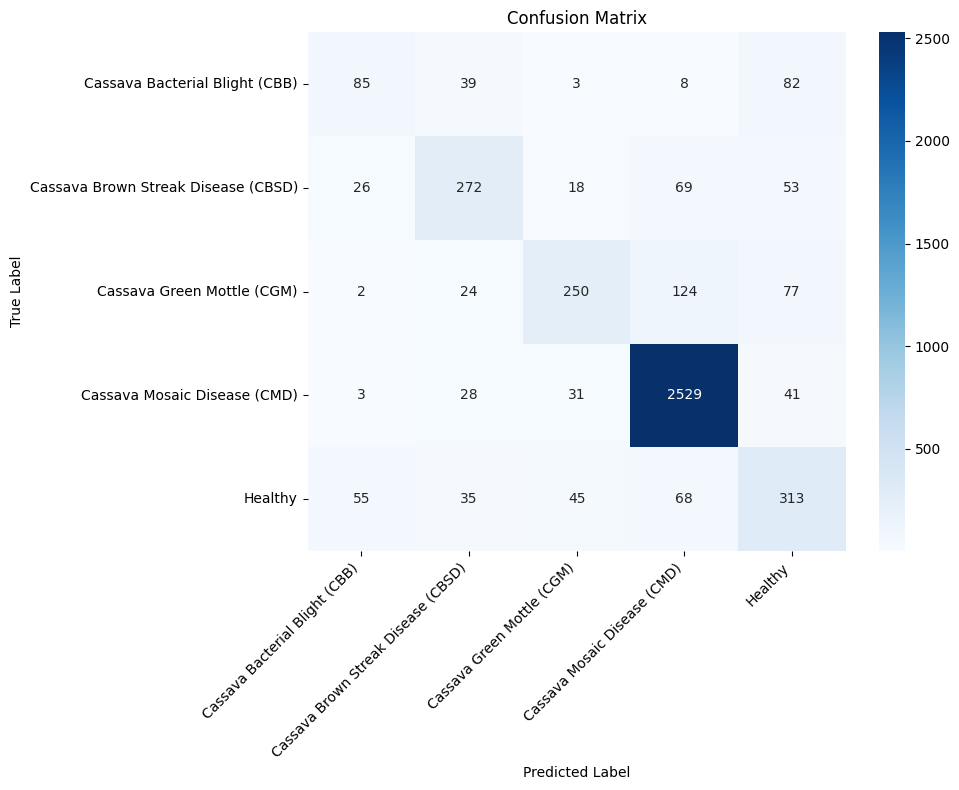

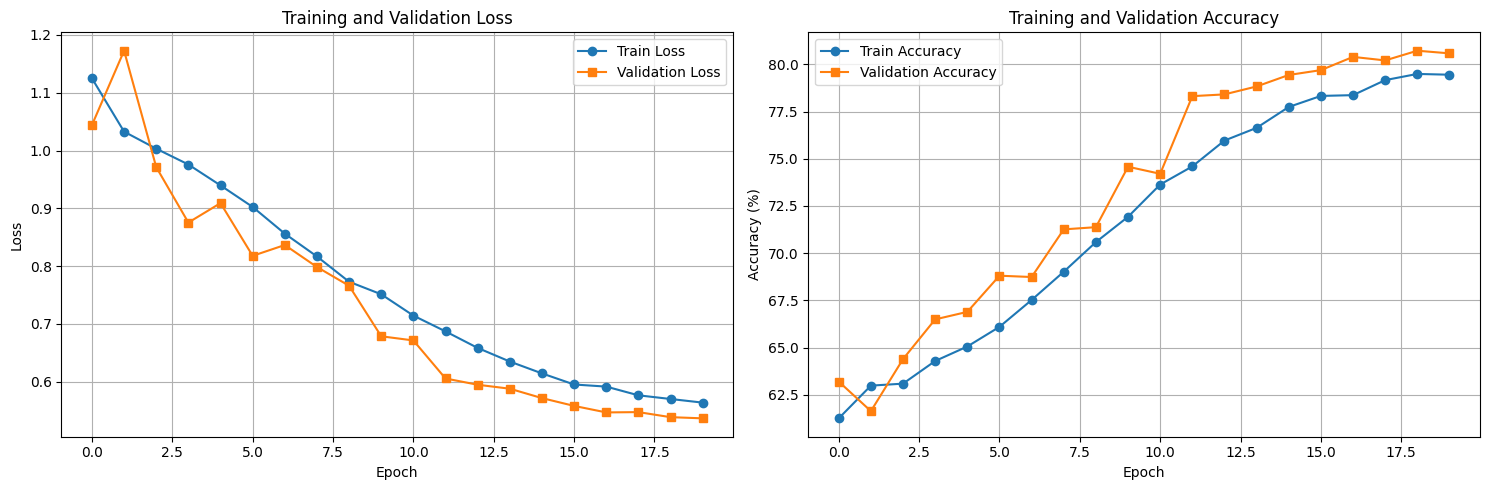


Best model saved at: best_cassava_model.pth


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import  classification_report, confusion_matrix
import seaborn as sns

# from model import create_model

# from dataset import create_data_loaders, analyze_dataset


class CassavaTrainer:
    def __init__(self, model, train_loader, val_loader, class_names, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.class_names = class_names
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self, optimizer, criterion, epoch):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1} [Train]')
        for batch_idx, batch in enumerate(pbar):
            images = batch['image'].to(self.device)
            labels = batch['label'].to(self.device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate_epoch(self, criterion, epoch):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc=f'Epoch {epoch+1} [Val]')
            for batch_idx, batch in enumerate(pbar):
                images = batch['image'].to(self.device)
                labels = batch['label'].to(self.device)
                
                # Forward pass
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Store predictions for detailed analysis
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_predictions, all_labels
    
    def train(self, num_epochs=10, lr=1e-3, weight_decay=1e-4, save_best=True):
        """Main training loop"""
        # Setup optimizer and scheduler
        optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
        criterion = nn.CrossEntropyLoss()
        
        best_val_acc = 0.0
        best_model_path = 'best_cassava_model.pth'
        
        print(f"Starting training for {num_epochs} epochs...")
        print(f"Device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            # Train
            train_loss, train_acc = self.train_epoch(optimizer, criterion, epoch)
            
            # Validate
            val_loss, val_acc, val_preds, val_labels = self.validate_epoch(criterion, epoch)
            
            # Update scheduler
            scheduler.step()
            
            # Store history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
            
            # Save best model
            if save_best and val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_loss': val_loss,
                    'class_names': self.class_names
                }, best_model_path)
                print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        
        print(f"\nTraining completed!")
        print(f"Best validation accuracy: {best_val_acc:.2f}%")
        
        # Generate final validation report
        self.generate_validation_report(val_preds, val_labels)
        
        return best_model_path
    
    def generate_validation_report(self, predictions, labels):
        """Generate detailed validation report"""
        print("\n" + "="*50)
        print("VALIDATION REPORT")
        print("="*50)
        
        # Classification report
        class_names_list = [self.class_names[i] for i in sorted(self.class_names.keys())]
        report = classification_report(labels, predictions, 
                                     target_names=class_names_list, 
                                     digits=4)
        print("\nClassification Report:")
        print(report)
        
        # Confusion matrix
        cm = confusion_matrix(labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names_list,
                   yticklabels=class_names_list)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy plot
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()


def main():
    # Configuration
    config = {
        'csv_file': '/kaggle/input/cassava-leaf-disease-classification/train.csv',
        'img_dir': '/kaggle/input/cassava-leaf-disease-classification/train_images',
        'batch_size': 32,
        'val_split': 0.2,
        'input_size': 224,
        'num_workers': 2,
        'num_epochs': 20,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'num_classes': 5
    }
    
    # Update paths for local development if needed
    if not os.path.exists(config['csv_file']):
        print("Kaggle paths not found. Please update the paths in the config.")
        return
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Analyze dataset
    print("Analyzing dataset...")
    analyze_dataset(config['csv_file'], config['img_dir'])
    
    # Create data loaders
    print("\nCreating data loaders...")
    train_loader, val_loader, class_names = create_data_loaders(
        csv_file=config['csv_file'],
        img_dir=config['img_dir'],
        batch_size=config['batch_size'],
        val_split=config['val_split'],
        input_size=config['input_size'],
        num_workers=config['num_workers']
    )
    
    # Create model
    print("\nCreating model...")
    model = create_model("tf_efficientnet_b4_ns", 
                        pretrained=False, 
                        num_classes=config['num_classes'])
    
    # Create trainer
    trainer = CassavaTrainer(model, train_loader, val_loader, class_names, device)
    
    # Train model
    best_model_path = trainer.train(
        num_epochs=config['num_epochs'],
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    
    # Plot training history
    trainer.plot_training_history()
    
    print(f"\nBest model saved at: {best_model_path}")


if __name__ == "__main__":
    main()


=== Cassava Dataset Example ===

1. Dataset Analysis:
=== Dataset Analysis ===
Total samples: 21397
Number of classes: 5

Class distribution:
Class 0 (Cassava Bacterial Blight (CBB)): 1087 samples (5.08%)
Class 1 (Cassava Brown Streak Disease (CBSD)): 2189 samples (10.23%)
Class 2 (Cassava Green Mottle (CGM)): 2386 samples (11.15%)
Class 3 (Cassava Mosaic Disease (CMD)): 13158 samples (61.49%)
Class 4 (Healthy): 2577 samples (12.04%)

Checking for missing images...
All images found!

Analyzing sample image sizes...
Image size range: 800x600 to 800x600
Average size: 800x600

2. Creating Data Loaders:
Training samples: 17117
Validation samples: 4280

Training set class distribution:
label
0      870
1     1751
2     1909
3    10526
4     2061
Name: count, dtype: int64

Validation set class distribution:
label
0     217
1     438
2     477
3    2632
4     516
Name: count, dtype: int64
Train batches: 1069
Validation batches: 268
Class names: {0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassav

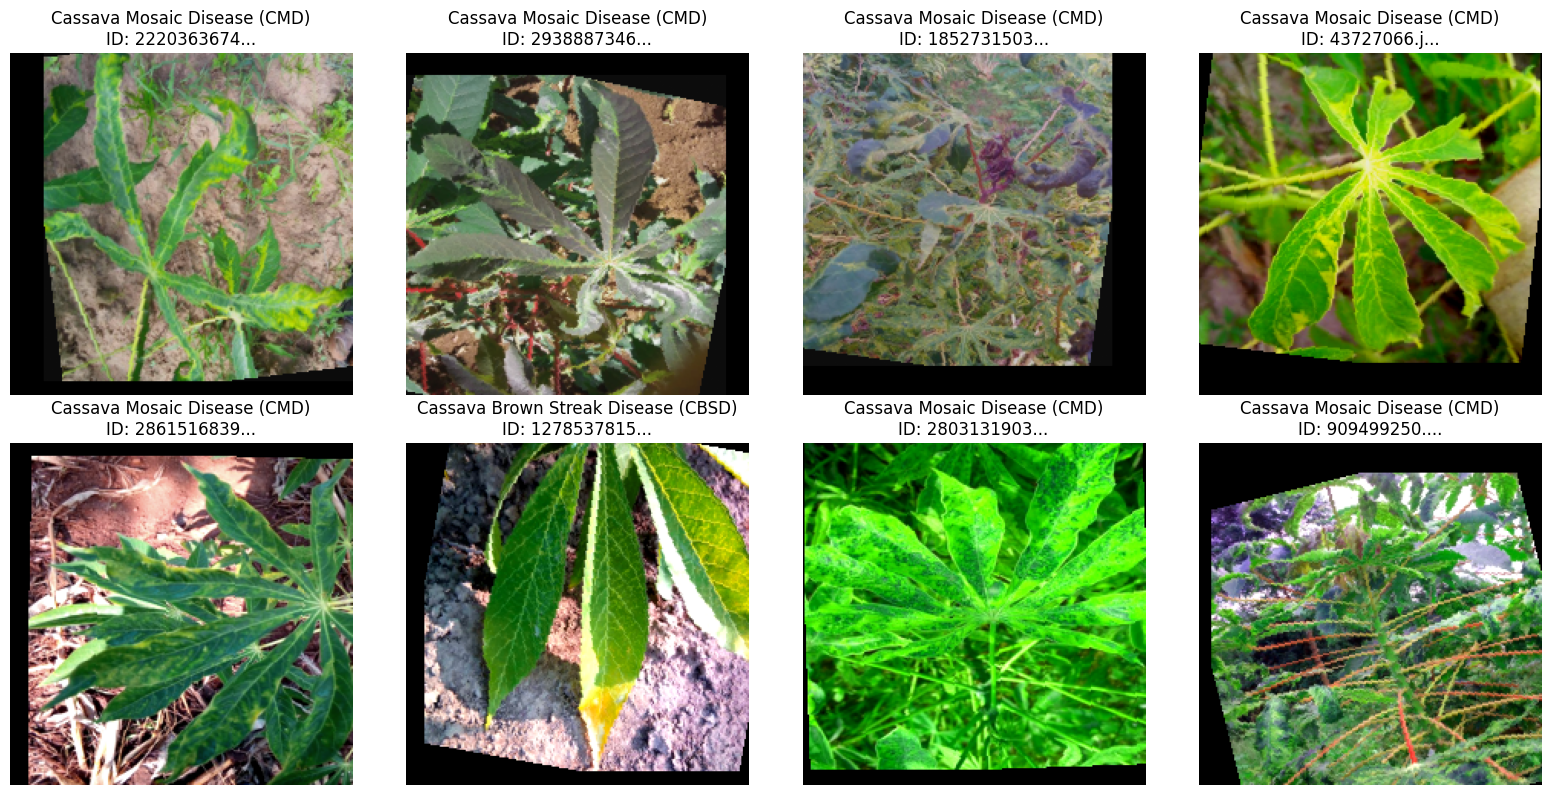


4. Testing Model Creation:
Model created successfully!
Total parameters: 17,557,581

5. Testing Forward Pass:
Input shape: torch.Size([16, 3, 224, 224])
Output shape: torch.Size([16, 5])
Sample predictions: [2 1 1 1 1]
Sample true labels: [1 4 4 3 3]

=== Setup Complete! ===
You can now use train.py to start training your model.


In [ ]:
"""
Example usage of the Cassava Dataset for training
Update the paths according to your local setup
"""
# from dataset import create_data_loaders, analyze_dataset
# from model import create_model

def visualize_batch(data_loader, class_names, num_samples=8):
    """Visualize a batch of images with their labels"""
    # Get a batch
    batch = next(iter(data_loader))
    images = batch['image']
    labels = batch['label']
    image_ids = batch['image_id']
    
    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        # Denormalize
        img = images[i] * std + mean
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose
        img_np = img.permute(1, 2, 0).numpy()
        
        # Plot
        axes[i].imshow(img_np)
        axes[i].set_title(f'{class_names[labels[i].item()]}\nID: {image_ids[i][:10]}...')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_batch.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Update these paths according to your setup
    csv_file = "/kaggle/input/cassava-leaf-disease-classification/train.csv"
    img_dir = "/kaggle/input/cassava-leaf-disease-classification/train_images"
    
    # For local development, you might use:
    # csv_file = "path/to/your/train.csv"
    # img_dir = "path/to/your/train_images"
    
    if not os.path.exists(csv_file):
        print("Please update the file paths in this script to match your setup.")
        print("Current paths:")
        print(f"CSV file: {csv_file}")
        print(f"Image directory: {img_dir}")
        return
    
    print("=== Cassava Dataset Example ===")
    
    # Analyze the dataset
    print("\n1. Dataset Analysis:")
    analyze_dataset(csv_file, img_dir)
    
    # Create data loaders
    print("\n2. Creating Data Loaders:")
    train_loader, val_loader, class_names = create_data_loaders(
        csv_file=csv_file,
        img_dir=img_dir,
        batch_size=16,
        val_split=0.2,
        input_size=224,
        num_workers=2
    )
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Class names: {class_names}")
    
    # Visualize some samples
    print("\n3. Visualizing Training Samples:")
    visualize_batch(train_loader, class_names)
    
    # Test model creation
    print("\n4. Testing Model Creation:")
    model = create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=5)
    print(f"Model created successfully!")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test forward pass
    print("\n5. Testing Forward Pass:")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Get a batch and test
    batch = next(iter(train_loader))
    images = batch['image'].to(device)
    labels = batch['label'].to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
    
    print(f"Input shape: {images.shape}")
    print(f"Output shape: {outputs.shape}")
    print(f"Sample predictions: {predictions[:5].cpu().numpy()}")
    print(f"Sample true labels: {labels[:5].cpu().numpy()}")
    
    print("\n=== Setup Complete! ===")
    print("You can now use train.py to start training your model.")

if __name__ == "__main__":
    main()


=== Cassava Leaf Disease Classification Test ===
Loading trained model from best_cassava_model.pth
Model loaded! Best validation accuracy: 80.72%
Using device: cuda

Testing random samples from dataset...

Testing 3 random samples:

Image: 863348541.jpg
Predicted: 3 - Cassava Mosaic Disease (CMD)
Confidence: 0.9974 (99.74%)

All Class Probabilities:
Cassava Bacterial Blight (CBB)      0.0001 
Cassava Brown Streak Disease (CBSD) 0.0002 
Cassava Green Mottle (CGM)          0.0011 
Cassava Mosaic Disease (CMD)        0.9974 █████████████████████████████
Healthy                             0.0012 


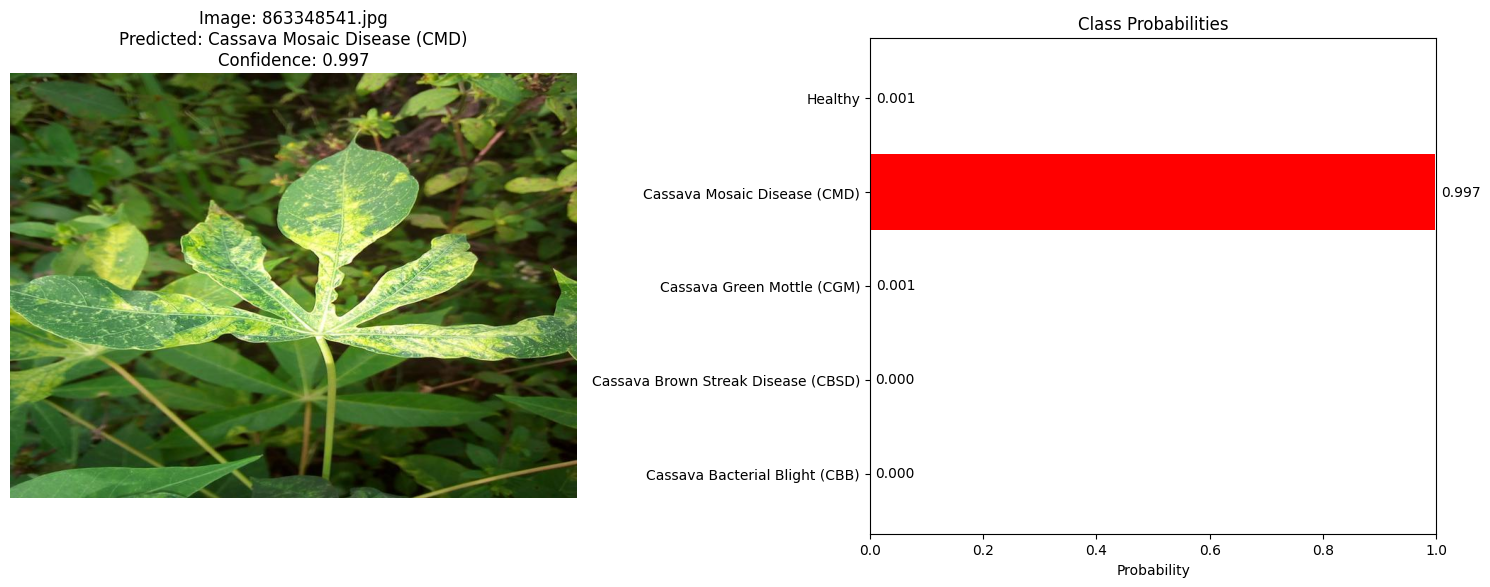


True: 3 (Cassava Mosaic Disease (CMD))
Pred: 3 (Cassava Mosaic Disease (CMD)) - 0.997
Status: ✓ CORRECT

Image: 3452699248.jpg
Predicted: 3 - Cassava Mosaic Disease (CMD)
Confidence: 0.9166 (91.66%)

All Class Probabilities:
Cassava Bacterial Blight (CBB)      0.0159 
Cassava Brown Streak Disease (CBSD) 0.0472 █
Cassava Green Mottle (CGM)          0.0052 
Cassava Mosaic Disease (CMD)        0.9166 ███████████████████████████
Healthy                             0.0151 


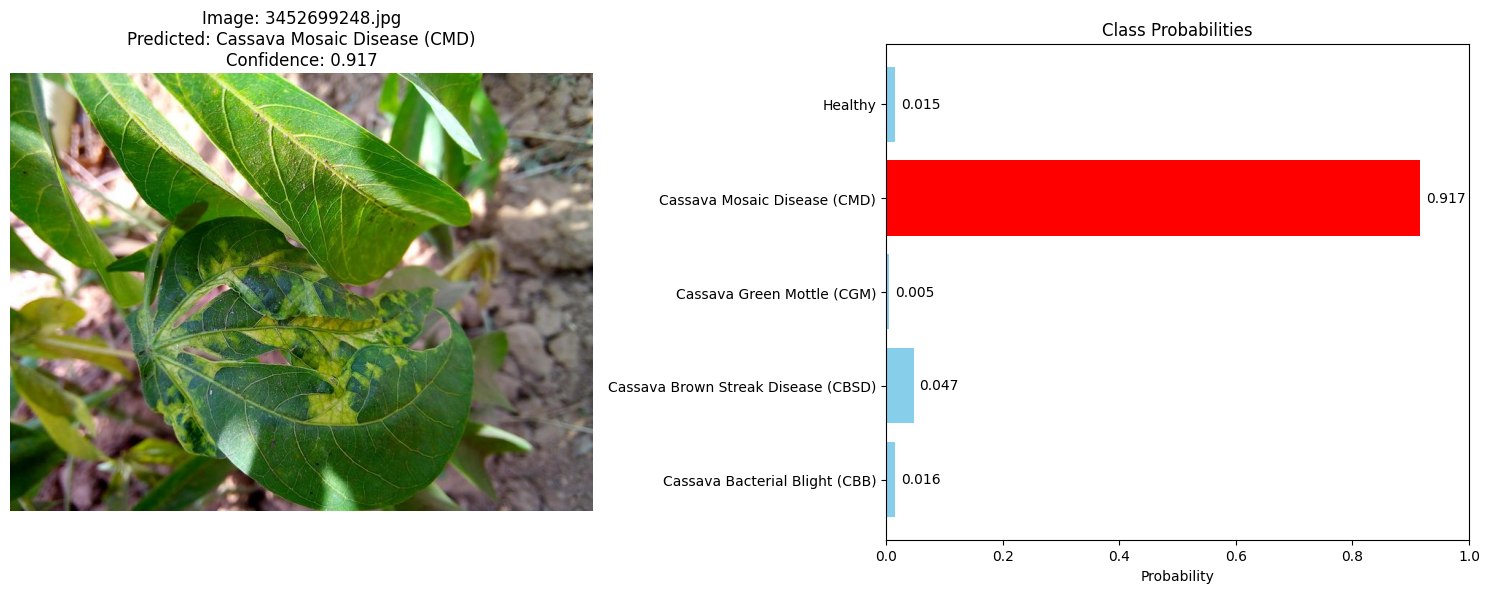


True: 3 (Cassava Mosaic Disease (CMD))
Pred: 3 (Cassava Mosaic Disease (CMD)) - 0.917
Status: ✓ CORRECT

Image: 624911036.jpg
Predicted: 3 - Cassava Mosaic Disease (CMD)
Confidence: 0.9457 (94.57%)

All Class Probabilities:
Cassava Bacterial Blight (CBB)      0.0021 
Cassava Brown Streak Disease (CBSD) 0.0057 
Cassava Green Mottle (CGM)          0.0232 
Cassava Mosaic Disease (CMD)        0.9457 ████████████████████████████
Healthy                             0.0233 


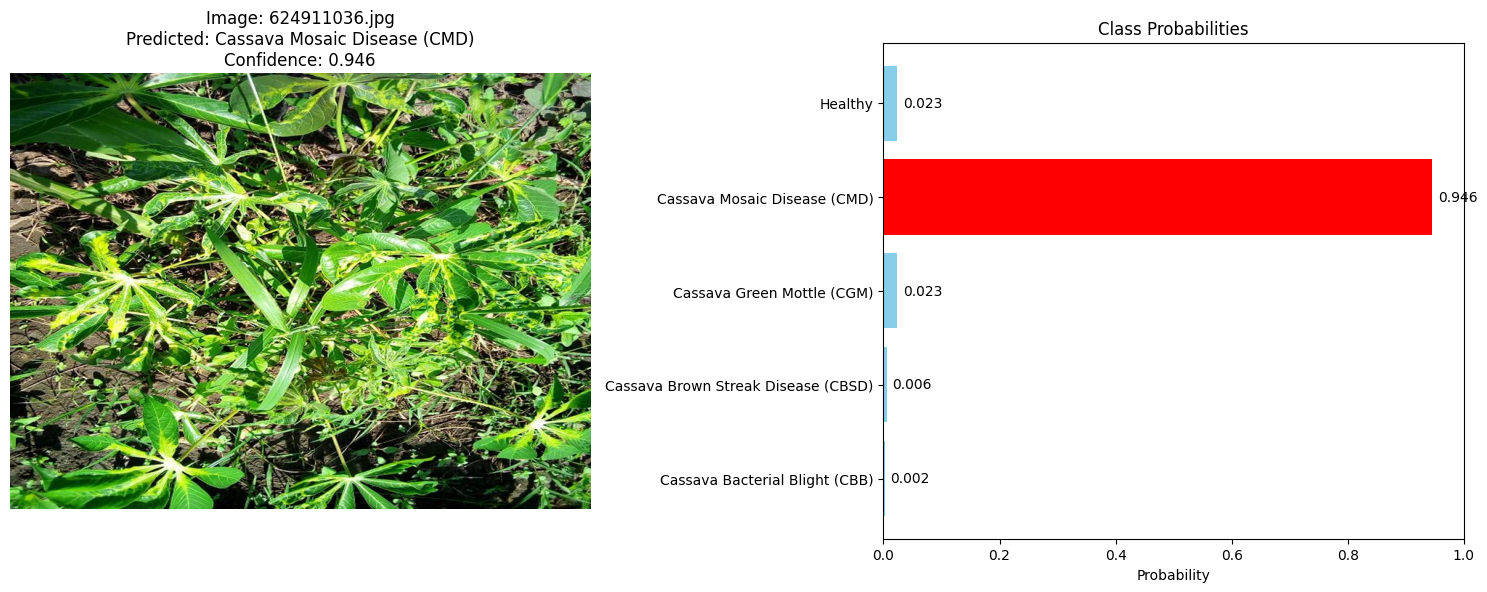


True: 3 (Cassava Mosaic Disease (CMD))
Pred: 3 (Cassava Mosaic Disease (CMD)) - 0.946
Status: ✓ CORRECT

Accuracy: 3/3 = 100.00%


In [ ]:
"""
Simple script to test the Cassava model on individual images
Update the paths according to your setup
"""

# from model import create_model


def load_model(model_path=None, device='cuda'):
    """Load the trained model"""
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    
    # Create model
    model = create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=5)
    
    if model_path and os.path.exists(model_path):
        print(f"Loading trained model from {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded! Best validation accuracy: {checkpoint.get('val_acc', 'N/A'):.2f}%")
    else:
        print("No trained model found. Using randomly initialized weights.")
        print("Note: Predictions will be random until you train the model!")
    
    model = model.to(device)
    model.eval()
    return model, device


def predict_image(model, image_path, device):
    """Predict the class of a single image"""
    
    # Class names
    class_names = {
        0: 'Cassava Bacterial Blight (CBB)',
        1: 'Cassava Brown Streak Disease (CBSD)',
        2: 'Cassava Green Mottle (CGM)',
        3: 'Cassava Mosaic Disease (CMD)',
        4: 'Healthy'
    }
    
    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()
        
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            predicted_class = predicted.item()
            confidence_score = confidence.item()
            all_probs = probabilities[0].cpu().numpy()
        
        # Print results
        print(f"\n{'='*60}")
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Predicted: {predicted_class} - {class_names[predicted_class]}")
        print(f"Confidence: {confidence_score:.4f} ({confidence_score*100:.2f}%)")
        print(f"{'='*60}")
        
        print("\nAll Class Probabilities:")
        for i, prob in enumerate(all_probs):
            bar = "█" * int(prob * 30)
            print(f"{class_names[i]:<35} {prob:.4f} {bar}")
        
        # Visualize
        visualize_prediction(original_image, class_names, all_probs, predicted_class, 
                           confidence_score, os.path.basename(image_path))
        
        return predicted_class, confidence_score, all_probs
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None, None


def visualize_prediction(image, class_names, probabilities, predicted_class, confidence, filename):
    """Visualize the prediction results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display image
    ax1.imshow(image)
    ax1.set_title(f"Image: {filename}\nPredicted: {class_names[predicted_class]}\nConfidence: {confidence:.3f}")
    ax1.axis('off')
    
    # Display probability bars
    classes = list(class_names.values())
    colors = ['red' if i == predicted_class else 'skyblue' for i in range(len(classes))]
    
    bars = ax2.barh(classes, probabilities, color=colors)
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probabilities')
    ax2.set_xlim(0, 1)
    
    # Add values on bars
    for bar, prob in zip(bars, probabilities):
        ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{prob:.3f}', va='center')
    
    plt.tight_layout()
    plt.savefig(f'prediction_{filename.split(".")[0]}.png', dpi=300, bbox_inches='tight')
    plt.show()


def test_random_samples(model, csv_file, img_dir, device, num_samples=5):
    """Test random samples from the dataset"""
    
    class_names = {
        0: 'Cassava Bacterial Blight (CBB)',
        1: 'Cassava Brown Streak Disease (CBSD)',
        2: 'Cassava Green Mottle (CGM)',
        3: 'Cassava Mosaic Disease (CMD)',
        4: 'Healthy'
    }
    
    if not os.path.exists(csv_file):
        print(f"CSV file {csv_file} not found!")
        return
    
    df = pd.read_csv(csv_file)
    sample_df = df.sample(n=min(num_samples, len(df)))
    
    print(f"\nTesting {len(sample_df)} random samples:")
    print("="*80)
    
    correct = 0
    total = 0
    
    for _, row in sample_df.iterrows():
        img_path = os.path.join(img_dir, row['image_id'])
        true_label = row['label']
        
        if not os.path.exists(img_path):
            continue
        
        pred_class, confidence, _ = predict_image(model, img_path, device)
        
        if pred_class is not None:
            total += 1
            if pred_class == true_label:
                correct += 1
                status = "✓ CORRECT"
            else:
                status = "✗ INCORRECT"
            
            print(f"\nTrue: {true_label} ({class_names[true_label]})")
            print(f"Pred: {pred_class} ({class_names[pred_class]}) - {confidence:.3f}")
            print(f"Status: {status}")
    
    if total > 0:
        accuracy = correct / total
        print(f"\n{'='*50}")
        print(f"Accuracy: {correct}/{total} = {accuracy:.2%}")
        print(f"{'='*50}")


def main():
    """Main function to test the model"""
    
    # Configuration - Update these paths according to your setup
    config = {
        'model_path': 'best_cassava_model.pth',  # Path to your trained model
        'csv_file': '/kaggle/input/cassava-leaf-disease-classification/train.csv',
        'img_dir': '/kaggle/input/cassava-leaf-disease-classification/train_images',
        'test_image': None,  # Set to a specific image path if you want to test one image
        'device': 'cuda'
    }
    
    # For local development, you might use:
    # config['csv_file'] = 'path/to/your/train.csv'
    # config['img_dir'] = 'path/to/your/train_images'
    # config['test_image'] = 'path/to/your/test_image.jpg'
    
    print("=== Cassava Leaf Disease Classification Test ===")
    
    # Load model
    model, device = load_model(config['model_path'], config['device'])
    print(f"Using device: {device}")
    
    # Test specific image if provided
    if config['test_image'] and os.path.exists(config['test_image']):
        print(f"\nTesting specific image: {config['test_image']}")
        predict_image(model, config['test_image'], device)
    
    # Test random samples from dataset
    elif os.path.exists(config['csv_file']) and os.path.exists(config['img_dir']):
        print(f"\nTesting random samples from dataset...")
        test_random_samples(model, config['csv_file'], config['img_dir'], device, num_samples=3)
    
    else:
        print("\nNo valid test data found!")
        print("Please update the config paths in this script:")
        print(f"CSV file: {config['csv_file']}")
        print(f"Image directory: {config['img_dir']}")
        print(f"Test image: {config['test_image']}")
        
        # Try to find any image files in current directory
        current_dir_images = [f for f in os.listdir('.') 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        if current_dir_images:
            print(f"\nFound images in current directory: {current_dir_images}")
            test_img = current_dir_images[0]
            print(f"Testing with {test_img}...")
            predict_image(model, test_img, device)


if __name__ == "__main__":
    main()


In [ ]:
"""
Simple script to generate submission.csv for Cassava Leaf Disease Classification
Update the paths according to your setup
"""


# from model import create_model


def generate_submission(model_path, test_dir, output_file='submission.csv', use_tta=False):
    """
    Generate submission file for Cassava competition
    
    Args:
        model_path: Path to trained model (.pth file)
        test_dir: Directory containing test images
        output_file: Output CSV file name
        use_tta: Whether to use Test Time Augmentation for better accuracy
    """
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load model
    print("Loading model...")
    model = create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=5)
    
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded! Validation accuracy: {checkpoint.get('val_acc', 'N/A'):.2f}%")
    else:
        print(f"Warning: Model file {model_path} not found!")
        print("Using randomly initialized weights - predictions will be random!")
    
    model = model.to(device)
    model.eval()
    
    # Get test images
    if not os.path.exists(test_dir):
        print(f"Test directory {test_dir} does not exist!")
        return
    
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = [f for f in os.listdir(test_dir) 
                   if any(f.lower().endswith(ext) for ext in image_extensions)]
    image_files.sort()
    
    print(f"Found {len(image_files)} test images")
    
    if len(image_files) == 0:
        print("No test images found!")
        return
    
    # Define transforms
    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # TTA transforms (if enabled)
    tta_transforms = [
        base_transform,  # Original
        transforms.Compose([  # Horizontal flip
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([  # Vertical flip
            transforms.Resize((224, 224)),
            transforms.RandomVerticalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    ]
    
    # Generate predictions
    predictions = []
    image_ids = []
    
    print(f"Generating predictions... (TTA: {use_tta})")
    
    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(test_dir, img_file)
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            if use_tta:
                # Test Time Augmentation
                all_preds = []
                for transform in tta_transforms:
                    img_tensor = transform(image).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        outputs = model(img_tensor)
                        probs = F.softmax(outputs, dim=1)
                        all_preds.append(probs.cpu().numpy()[0])
                
                # Average predictions
                avg_probs = np.mean(all_preds, axis=0)
                predicted_class = np.argmax(avg_probs)
            
            else:
                # Single prediction
                img_tensor = base_transform(image).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    outputs = model(img_tensor)
                    probs = F.softmax(outputs, dim=1)
                    predicted_class = torch.argmax(probs, dim=1).item()
            
            predictions.append(predicted_class)
            image_ids.append(img_file)
            
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            predictions.append(3)  # Default to most common class
            image_ids.append(img_file)
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'image_id': image_ids,
        'label': predictions
    })
    
    # Save submission
    submission_df.to_csv(output_file, index=False)
    
    # Print results
    print(f"\n{'='*50}")
    print(f"Submission saved to: {output_file}")
    print(f"Total predictions: {len(submission_df)}")
    print(f"{'='*50}")
    
    print("\nPrediction distribution:")
    class_names = {
        0: 'Cassava Bacterial Blight (CBB)',
        1: 'Cassava Brown Streak Disease (CBSD)',
        2: 'Cassava Green Mottle (CGM)',
        3: 'Cassava Mosaic Disease (CMD)',
        4: 'Healthy'
    }
    
    pred_counts = submission_df['label'].value_counts().sort_index()
    for label, count in pred_counts.items():
        percentage = (count / len(submission_df)) * 100
        print(f"Class {label} ({class_names[label]}): {count} ({percentage:.1f}%)")
    
    print(f"\nFirst 10 predictions:")
    print(submission_df.head(10))
    
    return submission_df


def create_sample_submission_template(test_dir, output_file='sample_submission.csv'):
    """Create a sample submission template"""
    
    if not os.path.exists(test_dir):
        print(f"Test directory {test_dir} does not exist!")
        return
    
    # Get all image files
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = [f for f in os.listdir(test_dir) 
                   if any(f.lower().endswith(ext) for ext in image_extensions)]
    image_files.sort()
    
    # Create template with dummy labels (all 0s)
    template_df = pd.DataFrame({
        'image_id': image_files,
        'label': [0] * len(image_files)
    })
    
    template_df.to_csv(output_file, index=False)
    
    print(f"Sample submission template created: {output_file}")
    print(f"Contains {len(template_df)} entries")
    print("\nTemplate format:")
    print(template_df.head())
    
    return template_df


def main():
    """Main function"""
    
    # Configuration - Update these paths according to your setup
    config = {
        'model_path': 'best_cassava_model.pth',  # Path to your trained model
        'test_dir': '/kaggle/input/cassava-leaf-disease-classification/test_images',  # Test images directory
        # 'test_dir': '/kaggle/working/',  # Test images directory
        'output_file': 'submission.csv',  # Output submission file
        'use_tta': True,  # Use Test Time Augmentation for better accuracy (slower)
        'create_template': False  # Set to True to create sample_submission.csv template
    }
    
    # For local development, you might use:
    # config['test_dir'] = 'path/to/your/test_images'
    # config['model_path'] = 'path/to/your/model.pth'
    
    print("=== Cassava Submission Generator ===")
    
    if config['create_template']:
        # Create sample submission template
        create_sample_submission_template(config['test_dir'], 'sample_submission.csv')
    else:
        # Generate actual submission
        generate_submission(
            model_path=config['model_path'],
            test_dir=config['test_dir'],
            output_file=config['output_file'],
            use_tta=config['use_tta']
        )
    
    print("\nDone!")


if __name__ == "__main__":
    main()


=== Cassava Submission Generator ===
Using device: cuda
Loading model...
Model loaded! Validation accuracy: 80.72%
Found 1 test images
Generating predictions... (TTA: True)


Processing images: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


Submission saved to: submission.csv
Total predictions: 1

Prediction distribution:
Class 3 (Cassava Mosaic Disease (CMD)): 1 (100.0%)

First 10 predictions:
         image_id  label
0  2216849948.jpg      3

Done!
